In [1]:
import numpy as np
import random
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from torchinfo import summary

from src.const import SEED
from src.evaluation import eval_acc_in_binary_task
from src.preprocess import transform_to_data_loader, preprocess_silence
from src.train import train_model
from src.visualization import plot_conf_matrix, plot_losses

Before running this notebook you must run `Preprocess.ipynb` notebook to prepare every dataset used here!!!

In [2]:
CLASSES = ['silence', 'sound']

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

Load and preprocess data

In [4]:
sound = np.load('data/arrays/X_train.npy')
silence = np.load("silence.npy")

silence = preprocess_silence(silence)

sound_indices = random.sample(range(1, sound.shape[0]), silence.shape[0])
sound = sound[sound_indices]

X_silence = np.concatenate((silence, sound), 0)
y_silence = np.concatenate((np.ones(silence.shape[0]), np.zeros(sound.shape[0])), 0)

Processing...: 100%|██████████| 4378/4378 [00:12<00:00, 353.76it/s]


Split for train and validation

In [5]:
X_train, X_val, y_train, y_val = train_test_split(
    X_silence, y_silence, test_size=0.2, random_state=42
)

Generate data loaders for train and validation

In [6]:
train_dl = transform_to_data_loader(X_train, y_train, device=device)
val_dl = transform_to_data_loader(X_val, y_val, device=device)

In [7]:
for x, y in train_dl:
    print(f'Input size: {x.shape}')
    print(f'Labels size: {y.shape}')
    break

Input size: torch.Size([128, 99, 20])
Labels size: torch.Size([128])


## Models

### Transformer

In [8]:
class Transformer(nn.Module):
    
    def __init__(self, d_model, n_head, num_layers, dropout_rate=0.3, units=16):
        
        torch.manual_seed(SEED)
        random.seed(SEED)
        np.random.seed(SEED)

        super().__init__()
        self.trans_enc_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=n_head, batch_first=True, activation="relu").to(device)
        self.transformer_encoder = nn.TransformerEncoder(self.trans_enc_layer, num_layers=num_layers).to(device)
        self.dropout = nn.Dropout(dropout_rate)
        self.fc1 = nn.Linear(d_model, units)
        self.fc2 = nn.Linear(units, 1)
        self.bc1 = nn.BatchNorm1d(d_model)
        self.bc2 = nn.BatchNorm1d(units)
        self.sigmoid = nn.Sigmoid()
        self.relu = nn.ReLU()

    def forward(self, x):
        out = self.transformer_encoder(x)[:, -1, :]
        out = self.dropout(out)
        out = self.bc1(out)
        out = self.fc1(out)
        out = self.dropout(out)
        out = self.relu(out)
        out = self.bc2(out)
        out = self.fc2(out)
        out = self.sigmoid(out)
        return out

In [9]:
d_model = 20
n_head = 4
num_layers = 1

transformer_model = Transformer(d_model, n_head, num_layers).to(device)
criterion = nn.BCELoss()
optimizer = optim.Adam(transformer_model.parameters(), weight_decay=1e-5)

In [10]:
summary(transformer_model, input_size=(128, 99, 20))

Layer (type:depth-idx)                        Output Shape              Param #
Transformer                                   [128, 1]                  85,748
├─TransformerEncoder: 1-1                     [128, 99, 20]             --
│    └─ModuleList: 2-1                        --                        --
│    │    └─TransformerEncoderLayer: 3-1      [128, 99, 20]             85,748
├─Dropout: 1-2                                [128, 20]                 --
├─BatchNorm1d: 1-3                            [128, 20]                 40
├─Linear: 1-4                                 [128, 16]                 336
├─Dropout: 1-5                                [128, 16]                 --
├─ReLU: 1-6                                   [128, 16]                 --
├─BatchNorm1d: 1-7                            [128, 16]                 32
├─Linear: 1-8                                 [128, 1]                  17
├─Sigmoid: 1-9                                [128, 1]                  --
Total param

In [11]:
train_losses, val_losses = train_model(
    model=transformer_model,
    criterion=criterion,
    optimizer=optimizer,
    train_loader=train_dl,
    val_loader=val_dl, 
    model_type="bin", 
    epoch_count=50,
    device=device,
    early_stopping=True,
)

Epoch 1:   0%|          | 0/55 [00:00<?, ?it/s]c:\Users\lukgr\anaconda3\envs\venv\lib\site-packages\torch\nn\functional.py:5476: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:263.)
  attn_output = scaled_dot_product_attention(q, k, v, attn_mask, dropout_p, is_causal)
Epoch 1: 100%|██████████| 55/55 [00:01<00:00, 27.74it/s]


Epoch 1/50, Train Loss: 0.5965, Train Acc: 0.69, Val Loss: 0.5085, Val Acc: 0.76


Epoch 2: 100%|██████████| 55/55 [00:01<00:00, 37.16it/s]


Epoch 2/50, Train Loss: 0.4820, Train Acc: 0.78, Val Loss: 0.3890, Val Acc: 0.83


Epoch 3: 100%|██████████| 55/55 [00:01<00:00, 37.90it/s]


Epoch 3/50, Train Loss: 0.3494, Train Acc: 0.86, Val Loss: 0.2386, Val Acc: 0.91


Epoch 4: 100%|██████████| 55/55 [00:01<00:00, 37.67it/s]


Epoch 4/50, Train Loss: 0.2205, Train Acc: 0.93, Val Loss: 0.1595, Val Acc: 0.95


Epoch 5: 100%|██████████| 55/55 [00:01<00:00, 38.50it/s]


Epoch 5/50, Train Loss: 0.1565, Train Acc: 0.95, Val Loss: 0.1414, Val Acc: 0.96


Epoch 6: 100%|██████████| 55/55 [00:01<00:00, 37.62it/s]


Epoch 6/50, Train Loss: 0.1194, Train Acc: 0.97, Val Loss: 0.1520, Val Acc: 0.95


Epoch 7: 100%|██████████| 55/55 [00:01<00:00, 38.26it/s]


Epoch 7/50, Train Loss: 0.1004, Train Acc: 0.97, Val Loss: 0.0800, Val Acc: 0.98


Epoch 8: 100%|██████████| 55/55 [00:01<00:00, 38.28it/s]


Epoch 8/50, Train Loss: 0.0831, Train Acc: 0.98, Val Loss: 0.0760, Val Acc: 0.98


Epoch 9: 100%|██████████| 55/55 [00:01<00:00, 37.86it/s]


Epoch 9/50, Train Loss: 0.0679, Train Acc: 0.98, Val Loss: 0.0637, Val Acc: 0.98


Epoch 10: 100%|██████████| 55/55 [00:01<00:00, 38.16it/s]


Epoch 10/50, Train Loss: 0.0606, Train Acc: 0.99, Val Loss: 0.0575, Val Acc: 0.98


Epoch 11: 100%|██████████| 55/55 [00:01<00:00, 37.52it/s]


Epoch 11/50, Train Loss: 0.0544, Train Acc: 0.99, Val Loss: 0.0850, Val Acc: 0.98


Epoch 12: 100%|██████████| 55/55 [00:01<00:00, 38.42it/s]


Epoch 12/50, Train Loss: 0.0467, Train Acc: 0.99, Val Loss: 0.0613, Val Acc: 0.98


Epoch 13: 100%|██████████| 55/55 [00:01<00:00, 37.01it/s]


Epoch 13/50, Train Loss: 0.0471, Train Acc: 0.99, Val Loss: 0.0661, Val Acc: 0.98
Early stopping


#### Evaluation

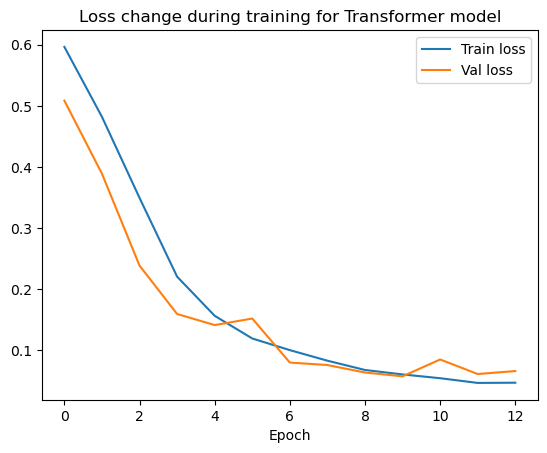

In [12]:
plot_losses(train_losses, val_losses, "Loss change during training for Transformer model")

In [14]:
eval_acc_in_binary_task(transformer_model, X_train, y_train, 'Train', device)
y_pred, acc = eval_acc_in_binary_task(transformer_model, X_val, y_val, 'Validation', device)

Train accuracy: 0.9959
Validation accuracy: 0.9834


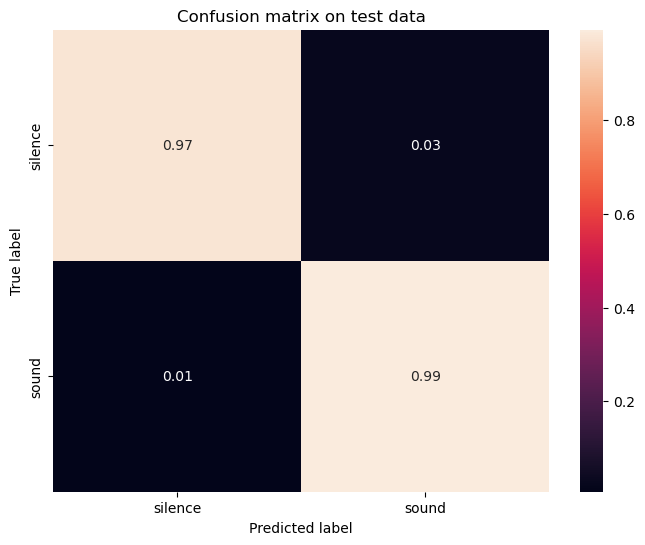

In [15]:
plot_conf_matrix(y_val, y_pred, CLASSES)

### GRU

In [8]:
class GRU(nn.Module):

    def __init__(self, input_size, hidden_size, num_layers=4, units=64, dropout_rate=0.3):
        torch.manual_seed(SEED)
        random.seed(SEED)
        np.random.seed(SEED)

        super().__init__()
        self.gru = nn.GRU(
            input_size=input_size, 
            hidden_size=hidden_size, 
            batch_first=True,
            num_layers=num_layers,
            dropout=dropout_rate,
        )
        self.dropout = nn.Dropout(dropout_rate)
        self.fc1 = nn.Linear(hidden_size, units)
        self.fc2 = nn.Linear(units, 1)
        self.bc1 = nn.BatchNorm1d(hidden_size)
        self.bc2 = nn.BatchNorm1d(units)
        self.sigmoid = nn.Sigmoid()
        self.relu = nn.ReLU()

    def forward(self, x):
        out = self.gru(x)[0][:, -1, :]
        out = self.dropout(out)
        out = self.bc1(out)
        out = self.fc1(out)
        out = self.dropout(out)
        out = self.relu(out)
        out = self.bc2(out)
        out = self.fc2(out)
        out = self.sigmoid(out)
        return out

In [13]:
input_size = 20
hidden_size = 16
num_layers = 2

gru_model = GRU(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers).to(device)
criterion = nn.BCELoss()
optimizer = optim.Adam(gru_model.parameters(), weight_decay=1e-5)

In [14]:
summary(gru_model, input_size=(128, 99, 20))

Layer (type:depth-idx)                   Output Shape              Param #
GRU                                      [128, 1]                  --
├─GRU: 1-1                               [128, 99, 16]             3,456
├─Dropout: 1-2                           [128, 16]                 --
├─BatchNorm1d: 1-3                       [128, 16]                 32
├─Linear: 1-4                            [128, 64]                 1,088
├─Dropout: 1-5                           [128, 64]                 --
├─ReLU: 1-6                              [128, 64]                 --
├─BatchNorm1d: 1-7                       [128, 64]                 128
├─Linear: 1-8                            [128, 1]                  65
├─Sigmoid: 1-9                           [128, 1]                  --
Total params: 4,769
Trainable params: 4,769
Non-trainable params: 0
Total mult-adds (M): 43.96
Input size (MB): 1.01
Forward/backward pass size (MB): 1.77
Params size (MB): 0.02
Estimated Total Size (MB): 2.80

In [15]:
train_dl = transform_to_data_loader(X_train, y_train, device=device)
val_dl = transform_to_data_loader(X_val, y_val, device=device)

train_losses, val_losses = train_model(
    model=gru_model,
    criterion=criterion,
    optimizer=optimizer,
    train_loader=train_dl,
    val_loader=val_dl, 
    model_type="bin", 
    epoch_count=50,
    device=device,
    early_stopping=True,
)

Epoch 1:   0%|          | 0/55 [00:00<?, ?it/s]

Epoch 1: 100%|██████████| 55/55 [00:00<00:00, 118.43it/s]


Epoch 1/50, Train Loss: 0.6384, Train Acc: 0.62, Val Loss: 0.5147, Val Acc: 0.77


Epoch 2: 100%|██████████| 55/55 [00:00<00:00, 131.69it/s]


Epoch 2/50, Train Loss: 0.5122, Train Acc: 0.75, Val Loss: 0.4493, Val Acc: 0.79


Epoch 3: 100%|██████████| 55/55 [00:00<00:00, 144.39it/s]


Epoch 3/50, Train Loss: 0.4570, Train Acc: 0.79, Val Loss: 0.4421, Val Acc: 0.79


Epoch 4: 100%|██████████| 55/55 [00:00<00:00, 147.67it/s]


Epoch 4/50, Train Loss: 0.4249, Train Acc: 0.81, Val Loss: 0.3695, Val Acc: 0.84


Epoch 5: 100%|██████████| 55/55 [00:00<00:00, 145.50it/s]


Epoch 5/50, Train Loss: 0.3528, Train Acc: 0.85, Val Loss: 0.2306, Val Acc: 0.92


Epoch 6: 100%|██████████| 55/55 [00:00<00:00, 137.08it/s]


Epoch 6/50, Train Loss: 0.1849, Train Acc: 0.94, Val Loss: 0.1111, Val Acc: 0.96


Epoch 7: 100%|██████████| 55/55 [00:00<00:00, 127.61it/s]


Epoch 7/50, Train Loss: 0.1271, Train Acc: 0.96, Val Loss: 0.0868, Val Acc: 0.97


Epoch 8: 100%|██████████| 55/55 [00:00<00:00, 138.89it/s]


Epoch 8/50, Train Loss: 0.1063, Train Acc: 0.97, Val Loss: 0.0777, Val Acc: 0.98


Epoch 9: 100%|██████████| 55/55 [00:00<00:00, 139.94it/s]


Epoch 9/50, Train Loss: 0.0965, Train Acc: 0.98, Val Loss: 0.0720, Val Acc: 0.98


Epoch 10: 100%|██████████| 55/55 [00:00<00:00, 140.67it/s]


Epoch 10/50, Train Loss: 0.0875, Train Acc: 0.98, Val Loss: 0.0643, Val Acc: 0.98


Epoch 11: 100%|██████████| 55/55 [00:00<00:00, 136.87it/s]


Epoch 11/50, Train Loss: 0.0845, Train Acc: 0.98, Val Loss: 0.0602, Val Acc: 0.98


Epoch 12: 100%|██████████| 55/55 [00:00<00:00, 132.21it/s]


Epoch 12/50, Train Loss: 0.0804, Train Acc: 0.98, Val Loss: 0.0690, Val Acc: 0.98


Epoch 13: 100%|██████████| 55/55 [00:00<00:00, 137.50it/s]


Epoch 13/50, Train Loss: 0.0723, Train Acc: 0.98, Val Loss: 0.0608, Val Acc: 0.99


Epoch 14: 100%|██████████| 55/55 [00:00<00:00, 143.22it/s]


Epoch 14/50, Train Loss: 0.0713, Train Acc: 0.98, Val Loss: 0.0575, Val Acc: 0.99


Epoch 15: 100%|██████████| 55/55 [00:00<00:00, 143.97it/s]


Epoch 15/50, Train Loss: 0.0697, Train Acc: 0.98, Val Loss: 0.0546, Val Acc: 0.99


Epoch 16: 100%|██████████| 55/55 [00:00<00:00, 142.33it/s]


Epoch 16/50, Train Loss: 0.0658, Train Acc: 0.99, Val Loss: 0.0547, Val Acc: 0.99


Epoch 17: 100%|██████████| 55/55 [00:00<00:00, 141.03it/s]


Epoch 17/50, Train Loss: 0.0672, Train Acc: 0.98, Val Loss: 0.0510, Val Acc: 0.99


Epoch 18: 100%|██████████| 55/55 [00:00<00:00, 135.14it/s]


Epoch 18/50, Train Loss: 0.0645, Train Acc: 0.98, Val Loss: 0.0673, Val Acc: 0.97


Epoch 19: 100%|██████████| 55/55 [00:00<00:00, 143.22it/s]


Epoch 19/50, Train Loss: 0.0596, Train Acc: 0.98, Val Loss: 0.0533, Val Acc: 0.98


Epoch 20: 100%|██████████| 55/55 [00:00<00:00, 138.89it/s]

Epoch 20/50, Train Loss: 0.0550, Train Acc: 0.99, Val Loss: 0.0579, Val Acc: 0.98
Early stopping


#### Evaluation

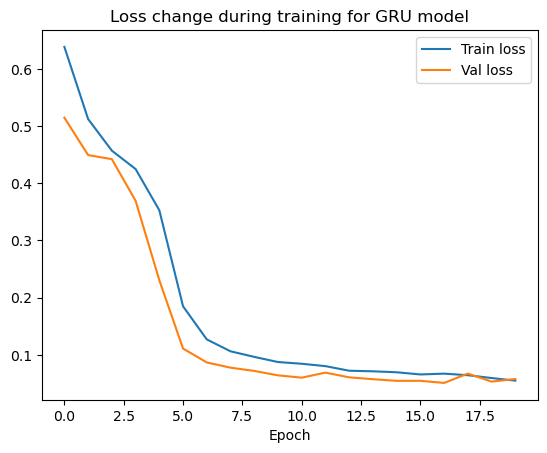

In [21]:
plot_losses(train_losses, val_losses, "Loss change during training for GRU model")

In [24]:
eval_acc_in_binary_task(gru_model, X_train, y_train, 'Train', device)
y_pred, acc = eval_acc_in_binary_task(gru_model, X_val, y_val, 'Validation', device)

Train accuracy: 0.9870
Validation accuracy: 0.9846


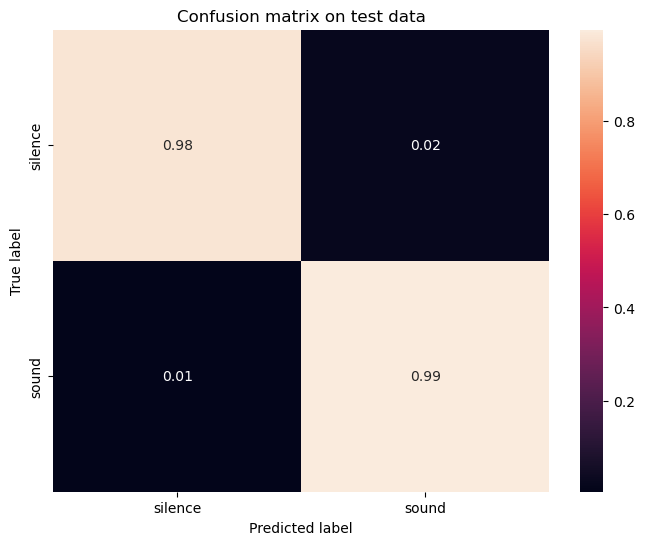

In [22]:
plot_conf_matrix(y_val, y_pred, CLASSES)

In [ ]:
# Save model dict as it is best model for this task
torch.save(gru_model.state_dict(), "models/silence_best_model")

### BI-LSTM

In [15]:
class BiLSTM(nn.Module):

    def __init__(self, input_size, hidden_size, num_layers=4, units=16, dropout_rate=0.2):
        torch.manual_seed(SEED)
        random.seed(SEED)
        np.random.seed(SEED)

        super().__init__()
        self.lstm = nn.LSTM(
            input_size=input_size, 
            hidden_size=hidden_size, 
            batch_first=True, 
            bidirectional=True, 
            num_layers=num_layers,
            dropout=dropout_rate,
        )
        self.dropout = nn.Dropout(dropout_rate)
        self.fc1 = nn.Linear(2*hidden_size, units)
        self.fc2 = nn.Linear(units, 1)
        self.bc1 = nn.BatchNorm1d(2*hidden_size)
        self.bc2 = nn.BatchNorm1d(units)
        self.sigmoid = nn.Sigmoid()
        self.relu = nn.ReLU()

    def forward(self, x):
        out = self.lstm(x)[0][:, -1, :]
        out = self.dropout(out)
        out = self.bc1(out)
        out = self.fc1(out)
        out = self.dropout(out)
        out = self.relu(out)
        out = self.bc2(out)
        out = self.fc2(out)
        out = self.sigmoid(out)
        return out

In [16]:
input_size = 20
hidden_size = 16
num_layers = 2

bilstm_model = BiLSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers).to(device)
criterion = nn.BCELoss()
optimizer = optim.Adam(bilstm_model.parameters(), weight_decay=1e-5)

In [17]:
summary(bilstm_model, input_size=(128, 99, 20))

Layer (type:depth-idx)                   Output Shape              Param #
BiLSTM                                   [128, 1]                  --
├─LSTM: 1-1                              [128, 99, 32]             11,264
├─Dropout: 1-2                           [128, 32]                 --
├─BatchNorm1d: 1-3                       [128, 32]                 64
├─Linear: 1-4                            [128, 16]                 528
├─Dropout: 1-5                           [128, 16]                 --
├─ReLU: 1-6                              [128, 16]                 --
├─BatchNorm1d: 1-7                       [128, 16]                 32
├─Linear: 1-8                            [128, 1]                  17
├─Sigmoid: 1-9                           [128, 1]                  --
Total params: 11,905
Trainable params: 11,905
Non-trainable params: 0
Total mult-adds (M): 142.82
Input size (MB): 1.01
Forward/backward pass size (MB): 3.31
Params size (MB): 0.05
Estimated Total Size (MB): 4.37

In [18]:
train_losses, val_losses = train_model(
    model=bilstm_model,
    criterion=criterion,
    optimizer=optimizer,
    train_loader=train_dl,
    val_loader=val_dl, 
    model_type="bin", 
    epoch_count=50,
    device=device,
    early_stopping=True,
)

Epoch 1: 100%|██████████| 55/55 [00:00<00:00, 129.49it/s]


Epoch 1/50, Train Loss: 0.6420, Train Acc: 0.64, Val Loss: 0.5601, Val Acc: 0.75


Epoch 2: 100%|██████████| 55/55 [00:00<00:00, 137.15it/s]


Epoch 2/50, Train Loss: 0.4900, Train Acc: 0.78, Val Loss: 0.4365, Val Acc: 0.80


Epoch 3: 100%|██████████| 55/55 [00:00<00:00, 125.99it/s]


Epoch 3/50, Train Loss: 0.4084, Train Acc: 0.83, Val Loss: 0.3077, Val Acc: 0.88


Epoch 4: 100%|██████████| 55/55 [00:00<00:00, 126.45it/s]


Epoch 4/50, Train Loss: 0.3136, Train Acc: 0.88, Val Loss: 0.2085, Val Acc: 0.94


Epoch 5: 100%|██████████| 55/55 [00:00<00:00, 118.90it/s]


Epoch 5/50, Train Loss: 0.2430, Train Acc: 0.92, Val Loss: 0.2161, Val Acc: 0.93


Epoch 6: 100%|██████████| 55/55 [00:00<00:00, 127.01it/s]


Epoch 6/50, Train Loss: 0.2059, Train Acc: 0.94, Val Loss: 0.1470, Val Acc: 0.96


Epoch 7: 100%|██████████| 55/55 [00:00<00:00, 132.53it/s]


Epoch 7/50, Train Loss: 0.1788, Train Acc: 0.95, Val Loss: 0.1434, Val Acc: 0.97


Epoch 8: 100%|██████████| 55/55 [00:00<00:00, 132.67it/s]


Epoch 8/50, Train Loss: 0.1615, Train Acc: 0.95, Val Loss: 0.1084, Val Acc: 0.97


Epoch 9: 100%|██████████| 55/55 [00:00<00:00, 130.14it/s]


Epoch 9/50, Train Loss: 0.1508, Train Acc: 0.96, Val Loss: 0.1061, Val Acc: 0.97


Epoch 10: 100%|██████████| 55/55 [00:00<00:00, 126.09it/s]


Epoch 10/50, Train Loss: 0.1228, Train Acc: 0.97, Val Loss: 0.0798, Val Acc: 0.98


Epoch 11: 100%|██████████| 55/55 [00:00<00:00, 124.14it/s]


Epoch 11/50, Train Loss: 0.1037, Train Acc: 0.97, Val Loss: 0.0682, Val Acc: 0.98


Epoch 12: 100%|██████████| 55/55 [00:00<00:00, 127.31it/s]


Epoch 12/50, Train Loss: 0.0963, Train Acc: 0.98, Val Loss: 0.1309, Val Acc: 0.96


Epoch 13: 100%|██████████| 55/55 [00:00<00:00, 127.32it/s]


Epoch 13/50, Train Loss: 0.0953, Train Acc: 0.97, Val Loss: 0.0623, Val Acc: 0.99


Epoch 14: 100%|██████████| 55/55 [00:00<00:00, 126.76it/s]


Epoch 14/50, Train Loss: 0.0812, Train Acc: 0.98, Val Loss: 0.0515, Val Acc: 0.99


Epoch 15: 100%|██████████| 55/55 [00:00<00:00, 130.09it/s]


Epoch 15/50, Train Loss: 0.0752, Train Acc: 0.98, Val Loss: 0.1639, Val Acc: 0.95


Epoch 16: 100%|██████████| 55/55 [00:00<00:00, 130.83it/s]


Epoch 16/50, Train Loss: 0.0895, Train Acc: 0.98, Val Loss: 0.0902, Val Acc: 0.97


Epoch 17: 100%|██████████| 55/55 [00:00<00:00, 128.50it/s]

Epoch 17/50, Train Loss: 0.0775, Train Acc: 0.98, Val Loss: 0.0553, Val Acc: 0.99
Early stopping


#### Evaluation

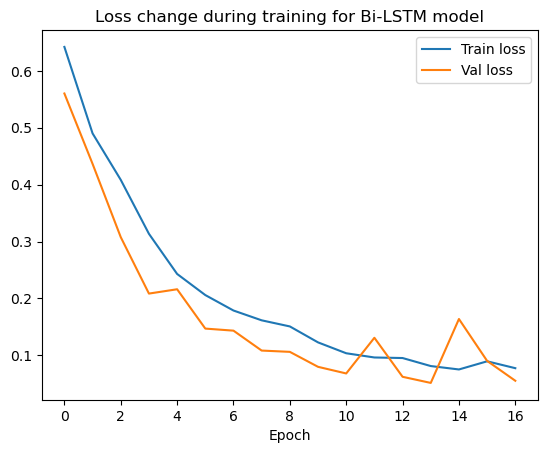

In [24]:
plot_losses(train_losses, val_losses, "Loss change during training for Bi-LSTM model")

In [25]:
eval_acc_in_binary_task(bilstm_model, X_train, y_train, 'Train', device)
y_pred, acc = eval_acc_in_binary_task(bilstm_model, X_val, y_val, 'Validation', device)

Train accuracy: 0.9864
Validation accuracy: 0.9852


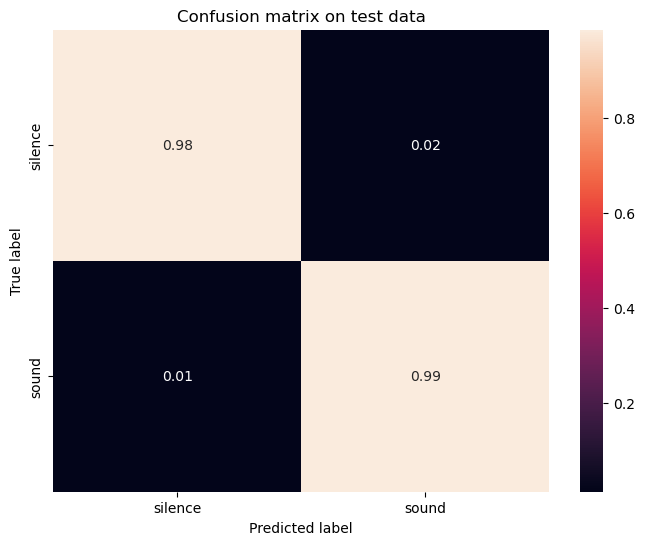

In [26]:
plot_conf_matrix(y_val, y_pred, CLASSES)